# Computational Social Science
# Text as Data - Content & Style Similarity 


Linus Dahlander and I have published multiple papers on <b>crowdsourcing</b>. The papers on [Distant Search](https://www.researchgate.net/publication/276182878_Distant_Search_Narrow_Attention_How_Crowding_Alters_Organizations'_Filtering_of_User_Suggestions) and [Rejections](https://www.researchgate.net/publication/326022890_Idea_Rejected_Tie_Formed_Organizations'_Feedback_on_Crowdsourced_Ideas) make use of <b>quantitative text analysis</b>. 

<div>
<img src="Screenshot - Distant Search, Narrow Attention.PNG"
     alt="Distant Search, Narrow Attention paper screenshot"
     style="float: left; margin-right: 10px; width: 30%; height: 30%" />

<img src="Screenshot - Distant Search, Narrow Attention.PNG"
     alt="Rejection paper screenshot"
     style="float: left; margin-right: 10px; width: 30%; height: 30%" />
</div>


Both papers have won prizes and people often ask about the code. Thus, I thought I make the code widely available so that people can easily engage with it. I have teamed up with my friend and long term collaboration partner Phil Reineke (a rockstar [PhD student at Stanford University](https://www.linkedin.com/in/preineke/)). We have refined the code and explain it in some detail. Our goal was to provide an overview to people who are new to quantitative text analysis.

The goal of this class and practice document is for you to get some ideas - and also to provide you with lots of code that you can steal and use for your own projects.

We integrated most comments directly in the code blocks so that you have commentar directly next to the functions without having to execute hundereds of tiny blocks with just a single line of code.

#### Setting up the environment
First we will set up our R environment and load some libraries that provide functions that we want to use. If you do not have the libraries listed under "loading libraries" and "libraries used but not loaded" installed, please do so by uncommenting the code in the first cell. The syntax that allows you to install a package is install.packages("package_name"). You may have to launch R outside of Jupyter to install these packages successfully.



In [1]:
################################################################################
# Installing libraries
################################################################################
# This code installs the necessary libraries. I already have them installed,
# therefore this code is commented out. You may not be able to install them from
# this textbox in Jupyter. Instead you may have to open a separate console 
# window, start R (by typing "R") and then execute the below line.

# install.packages("dplyr", "data.table", "tm", "sentimentr", "ggplot2", "stringr",
#                  "lsa", "reshape2", "SnowballC", repos='http://cran.us.r-project.org')

In [2]:
################################################################################
# Setting up environment
################################################################################
### cleaning the environment
rm(list = ls())

### loading libraries
library(dplyr)
library(data.table)
library(tm)
library(sentimentr)
library(ggplot2)

### libraries used but not loaded
# stringr
# lsa
# reshape2
# SnowballC


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: NLP


Attaching package: ‘ggplot2’


The following object is masked from ‘package:NLP’:

    annotate




#### Loading data

Now we are generating some simple text data ourselves so we have easy examples to understand the concepts.

In [3]:
data <- data.frame(text = c("The dog chases the cat!",
                            "The cat chases the mouse...",
                            "The dog chases the cat around the house.",
                            "The dog is in the house.",
                            "Damn, that's a damn large mouse, bro - +!&@",
                            "The dog is in the house. The dog is in the house!",
                            "Cats, dogs, and mice, are mammals.  ",
                            "An unrelated piece of text, he remarked. ",
                            "0001 dog, 0002, mouse, 0003 cat, 0004 hawk, ...",
                            "The mammals are interesting",
                            "The house was blue. Not any blue, but a very particular blue ",
                            "The dog seem to like blue, sky blue. I enjoy this class."),
                   stringsAsFactors = FALSE)

#### Computing basic variables

Now weare computing some basic text length variables.


In [4]:
################################################################################
# Computing Basic Text Variables
################################################################################
# ------------------------------------------------------------------------------
### Text length in characters
data$length_in_characters <- nchar(data$text)
print("Text length in characters")
print(data$length_in_characters)

# ------------------------------------------------------------------------------
### Text length in words
# we use "word breaks" as "space" characters. This is the most straightforward 
# method, but there are certainly functions in libraries that compute better 
# word counts scores that account for special conditions (e.g. in some cases 
# people use non-standard space characters that the function below would miss).
data$word_count <- unlist(lapply(strsplit(data$text, " "), length))
print("---------------------")
print("Text length in words")
print(data$word_count)

[1] "Text length in characters"
 [1] 23 27 40 24 43 49 36 41 47 27 61 56
[1] "---------------------"
[1] "Text length in words"
 [1]  5  5  8  6  9 12  7  7  9  4 12 12


#### Cleaning Text Data

Later on we want to compute similarity measures between different pieces of text. However, some words are very similar but are not exactly the same. For our simple approach below to work, we need words to be exactly the same to be able to successfully detect them as similar. For example "Going" and "going" and "rain" and "raining" are very similar but would not be detected as similar words in our uncleaned text. Therefore, we need to conduct some cleaning steps to make these words exactly the same and enable successful detection.

Later on we will compute another similarity measure called "Style Similarity". Cleaning words makes sense for assessing content different but not for assessing style difference. As such we will NOT clean the text (or at least not as extensively) when assessing style similarity later. 

We perform the following cleaning steps:


In [5]:
################################################################################
# Cleaning Text Data
################################################################################
### Making all words lowercase. 
# We do this because arguably (in most cases) upper and lowercase versions of 
# the same word have the same meaning and should be treated the same.
data$text_cleaned <- tolower(data$text)
print("Making all words lowercase")
print(data$text_cleaned)

### Removing punctuation (except for intra-word dashes)
# Most content in a sentence is contained in the words. Punctiation may 
# influnence our detection formulas, thus we remove any and all punctuation
# except for intra-word dashes. Note that for some variables punctuation might
# be important. E.g. we could classify people according to how often they use
# exclamation marks. If we wanted to do that mustn't delete punctuation!
data$text_cleaned <- tm::removePunctuation(data$text_cleaned, preserve_intra_word_dashes = TRUE)
print("---------------------")
print("Removing punctuation (except for intra-word dashes)")
print(data$text_cleaned)

### Removing numbers
# We delete numbers because usually numbers are very specific and don't hold
# information that can be compared or constrasted across cases. Since the
# relative amount of numbers a person is using can tell us something about that
# person's writing style we only clean those for content similarity.
data$text_cleaned <- tm::removeNumbers(data$text_cleaned)
print("---------------------")
print("Removing numbers")
print(data$text_cleaned)

### Removing stopwords
# Some words do not contain important significance because they appear in almost 
# every / a large amount of texts. Thus they are not good to compare or contrast
# texts and tend to add noise. Thus in some contexts they can be excluded. These
# are words such as "i", "me","my" etc. However, we only exclude them before
# computing content similarity, NOT when computing style similarity because 
# it may be important for the personal style of a person if he is using many
# words that might be classified as some kind of stopword.
data$text_cleaned <- tm::removeWords(data$text_cleaned, stopwords("english"))
print("---------------------")
print("Removing stopwords")
print(data$text_cleaned)

### Stemming words
# Some words have the same meaning / are the same words but they exist in the
# text in different conjugations. E.g. "run" and "ran". These have the same
# content / meaning but are difficult to compare directly. Therefore, we replace
# all those words with a common content stem. E.g. I "am" and you "are". Both 
# describe "being" just in different forms because of their subject. Those would
# therefore potentially both stemmed to "being", making comparisons easier. We
# can NOT do this in cases where the dictionary we are using in expecting "raw"
# (i.e. uncleaned) text. So we can only do stemming for content similarity.
data$text_cleaned <- tm::stemDocument(data$text_cleaned)
print("---------------------")
print("Stemming words")
print(data$text_cleaned)

### Removing duplicate whitespace characters
# Some words have multiple whitespace characters between each other. That
# can create issues with the splitting of sentences into words down the line. 
# Thus, we reduce multiple whitespaces between words to single whitespaces.
# In our case the stemming function alrady does this but we just do it again
# just to make sure.
data$text_cleaned <- tm::stripWhitespace(data$text_cleaned)
print("---------------------")
print("Removing duplicate whitespace characters")
print(data$text_cleaned)

### Removing whitespace characters at the beginning and end of a text
# Some sentences start or end with a whitespace. This can also cause problems
# with splitting words. Thus, we remove whitespaces at the very beginning or
# end of a string.
data$text_cleaned <- stringr::str_trim(data$text_cleaned)
print("---------------------")
print("Removing whitespace characters at the beginning and end of a text")
print(data$text_cleaned)

[1] "Making all words lowercase"
 [1] "the dog chases the cat!"                                      
 [2] "the cat chases the mouse..."                                  
 [3] "the dog chases the cat around the house."                     
 [4] "the dog is in the house."                                     
 [5] "damn, that's a damn large mouse, bro - +!&@"                  
 [6] "the dog is in the house. the dog is in the house!"            
 [7] "cats, dogs, and mice, are mammals.  "                         
 [8] "an unrelated piece of text, he remarked. "                    
 [9] "0001 dog, 0002, mouse, 0003 cat, 0004 hawk, ..."              
[10] "the mammals are interesting"                                  
[11] "the house was blue. not any blue, but a very particular blue "
[12] "the dog seem to like blue, sky blue. i enjoy this class."     
[1] "---------------------"
[1] "Removing punctuation (except for intra-word dashes)"
 [1] "the dog chases the cat"                        

#### Computing Content Similarity

We want to understand to what degree the text observations we generated above talk about the same type of content.

In [6]:
#######################################
# Calculating Content Similarity
#######################################
# First we create a Corpus using the cleaned text. That is a type of
# object from the "tm" package where each text is stored as counts
# of the single unique terms that appear in the .
td_matrix <- Corpus(VectorSource(data$text_cleaned))

# Then we extract this matrix from the corpus and store it as a normal R matrix.
# Each column represents a text, each row represents a single unique
# word / term that appears in some text. The matrix fields are counts 
# of the terms per text. This is now a document-term matrix (more 
# specifically a term-document matrix, because the terms are on the y- and the
# documents on the x- axis and by convention the y-axis is named first)

# Note: Importantly the suggestions in the column are ordered the same way in 
# which we passed them to the Corpus function. I.e. the first column represents
# the first suggestion etc. This is important because we will from now on work
# with the indices of the suggestions in the data table. I.e. if we
# talk about suggestion 5, that's the 5th suggestion and 5 will be the ID used
# in subsequent tables.
# To learn text analysis - you may spend some time coping with different kinds of data formats
td_matrix <- as.matrix(TermDocumentMatrix(td_matrix))
print("Term Document Matrix")
td_matrix

### Here we save a backup of the td_matrix for a subsequent analysis
td_matrix_backup <- td_matrix

# Now we create one version of the  apply weighting to correct for skewed data. 
# The lw_logtf function returns the log(m + 1) of each of the matrix elements.
td_matrix_lw    <- lsa::lw_logtf(td_matrix)
print("Weighted Term Document Matrix")
td_matrix_lw

# We also create a version that is weighted locally and globally. Global 
# weighting gives rare words more weight so that if two suggestions who have
# rare terms in common will yiels greater content_similarity scores when
# compared.
td_matrix_lw_gw <- td_matrix_lw * lsa::gw_idf(td_matrix)

# In order to compare each suggestion with each other suggestion in the matrix,
# we use the lsa package's "cosine" function. This calculates the cosine 
# similarity of each column to each other column. We get a square matrix with
# a number of rows and columns equal to the number of columns in our input
# matrix.
td_matrix <- lsa::cosine(td_matrix)

# In out output matrix, mirrored values are the same (so the cosine similarity 
# of A to B is the same as the one of B to A). We can delete one of the two 
# versions and only retain the other. Additionally, we do not need the diagonal
# of the matrix because the similarity of a suggestion with itself is always 1.
# We delete the superfluous values by setting the lower triangle of the matrix
# equal to NA.
td_matrix[lower.tri(td_matrix, diag = TRUE)] <- NA

# Now we turn the matrix into an (undirected) pairwise EDGE list. The ID values
# in this list indicate the "place" value of the suggestions in the 
# data (as noted above).
td_matrix <- reshape2::melt(td_matrix)

# We delete superfluous rows in the EDGE list of the values that we set NA 
# above.
td_matrix <- td_matrix[!is.na(td_matrix$value),]

# We give our new EDGE list and its variables more descriptive names.
EDGE <- td_matrix
colnames(EDGE) <- c("1", "2", "content_similarity")

# In order to not having to write lots of code every time we want to do the 
# above extraction for other matrices (such as the locally and globally
# weighted matrixes), we create a formula that does all the above steps at once.
# It also extracts the "value" part of our final edge list so we can directly
# integrate it into our existing edge list.

# Note that it is VERY important to make sure that the suggestions in the matrix
# passed to this function are in the exact same order as in the matrix used to
# create the initial edge list. If the ordering is different (but the number)
# of suggestions is the same, the function will produce output of the same size,
# but a completely different ordering. If you put the into the original EDGE
# list you will have wrong values associated with almost all suggestion ID
# pairs.
extract_cosine_similarity_from_matrix <- function(input_matrix) {
  input_matrix <- lsa::cosine(input_matrix)
  input_matrix[lower.tri(input_matrix, diag = TRUE)] <- NA
  input_matrix <- reshape2::melt(input_matrix)
  return(input_matrix[!is.na(input_matrix$value),"value"])
} 

# We use our new formula to extract the locally and globally weighted content
# similarity values and store them in our EDGE list.
EDGE$content_similarity_lw <- extract_cosine_similarity_from_matrix(td_matrix_lw)
EDGE$content_similarity_lw_gw <- extract_cosine_similarity_from_matrix(td_matrix_lw_gw)
print("Content Similarity EDGE Table")
EDGE

# We do some cleaning of our environment.
rm(td_matrix, td_matrix_lw, td_matrix_lw_gw)

[1] "Term Document Matrix"


,1,2,3,4,5,6,7,8,9,10,11,12
cat,1,1,1,0,0,0,1,0,1,0,0,0
chase,1,1,1,0,0,0,0,0,0,0,0,0
dog,1,0,1,1,0,2,1,0,1,0,0,1
mous,0,1,0,0,1,0,0,0,1,0,0,0
around,0,0,1,0,0,0,0,0,0,0,0,0
hous,0,0,1,1,0,2,0,0,0,0,1,0
bro,0,0,0,0,1,0,0,0,0,0,0,0
damn,0,0,0,0,2,0,0,0,0,0,0,0
larg,0,0,0,0,1,0,0,0,0,0,0,0
that,0,0,0,0,1,0,0,0,0,0,0,0


[1] "Weighted Term Document Matrix"


,1,2,3,4,5,6,7,8,9,10,11,12
cat,0.6931472,0.6931472,0.6931472,0.0000000,0.0000000,0.000000,0.6931472,0.0000000,0.6931472,0.0000000,0.0000000,0.0000000
chase,0.6931472,0.6931472,0.6931472,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
dog,0.6931472,0.0000000,0.6931472,0.6931472,0.0000000,1.098612,0.6931472,0.0000000,0.6931472,0.0000000,0.0000000,0.6931472
mous,0.0000000,0.6931472,0.0000000,0.0000000,0.6931472,0.000000,0.0000000,0.0000000,0.6931472,0.0000000,0.0000000,0.0000000
around,0.0000000,0.0000000,0.6931472,0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
hous,0.0000000,0.0000000,0.6931472,0.6931472,0.0000000,1.098612,0.0000000,0.0000000,0.0000000,0.0000000,0.6931472,0.0000000
bro,0.0000000,0.0000000,0.0000000,0.0000000,0.6931472,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
damn,0.0000000,0.0000000,0.0000000,0.0000000,1.0986123,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
larg,0.0000000,0.0000000,0.0000000,0.0000000,0.6931472,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
that,0.0000000,0.0000000,0.0000000,0.0000000,0.6931472,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


[1] "Content Similarity EDGE Table"


,1,2,content_similarity,content_similarity_lw,content_similarity_lw_gw
,<int>,<int>,<dbl>,<dbl>,<dbl>
13,1,2,0.6666667,0.6666667,0.7064509
25,1,3,0.7745967,0.7745967,0.6198015
26,2,3,0.5163978,0.5163978,0.4378593
37,1,4,0.4082483,0.4082483,0.2422952
38,2,4,0.0000000,0.0000000,0.0000000
39,3,4,0.6324555,0.6324555,0.4677410
49,1,5,0.0000000,0.0000000,0.0000000
50,2,5,0.2041241,0.2262448,0.1674938
51,3,5,0.0000000,0.0000000,0.0000000


#### Count analysis

Now we will generate some plots of terms counts to get a graphical overview over our data.

[1] "Term Counts"
       dog        cat       hous       blue      chase       mous       damn 
         8          5          5          5          3          3          2 
    mammal     around        bro       larg       that       mice       piec 
         2          1          1          1          1          1          1 
    remark       text      unrel       hawk   interest particular      class 
         1          1          1          1          1          1          1 
     enjoy       like       seem        sky 
         1          1          1          1 


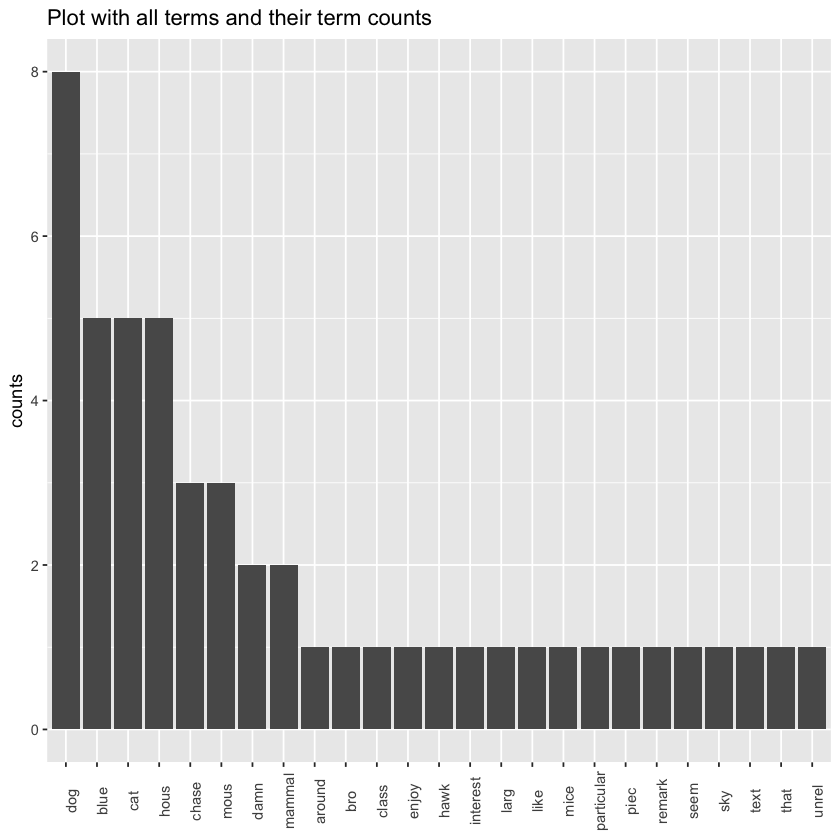

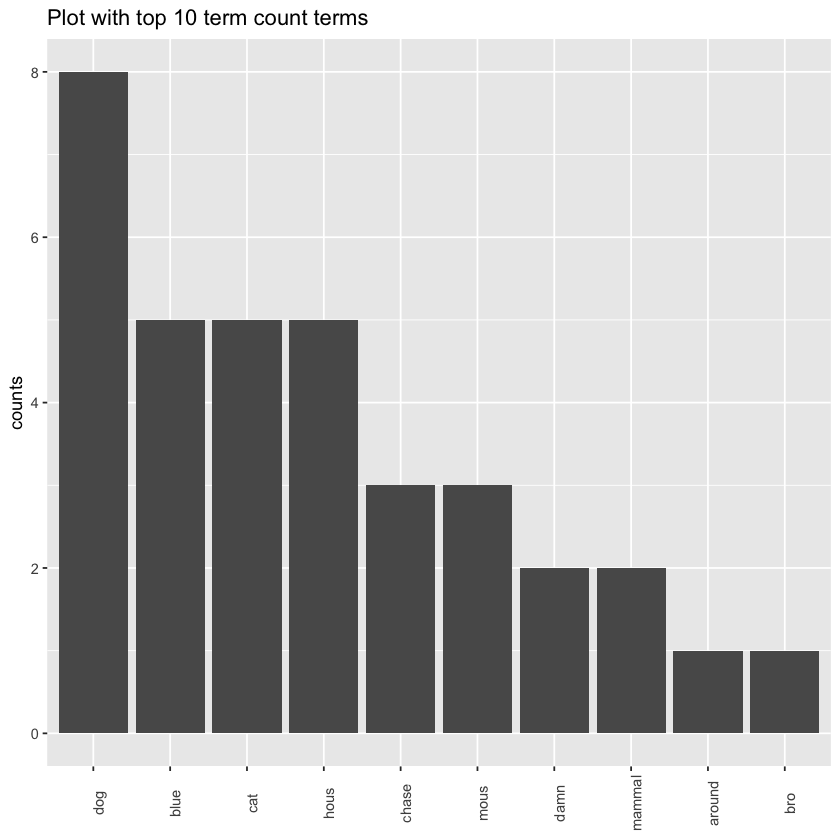

In [7]:
################################################################################
# Count analysis
################################################################################
# In the document term matrix we already have all data that we need to conduct
# a count analyses. Each row represents the counts for a specific term. By just
# summing across a row and sorting the outcome, we get the number of counts.
# Because the td_matrix contains cleaned words, here we are using
# stemmed versions of the words and exclude stopwords. However, the process can
# be done based on the original data analogously by using uncleaned data to 
# build the Term-Document matrix.
term_counts <- sort(rowSums(td_matrix_backup), decreasing = TRUE) 
print("Term Counts")
print(term_counts)

# This can be more nicely displayed in a plot. First we need to create a data
# frame because the ggplot2 plotting library expexts data in that format.
term_counts_data_frame <- data.frame(label = names(term_counts), counts = term_counts)

# creating plot
term_counts_plot_1 <- ggplot(data = term_counts_data_frame, aes(x = reorder(label, -counts), y = counts)) +
  geom_bar(stat = "identity") +
  theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 90)) +
  ggtitle("Plot with all terms and their term counts")
term_counts_plot_1   

# plot with only top 10 counts
term_counts_plot_2 <- ggplot(data = term_counts_data_frame[1:10,], aes(x = reorder(label, -counts), y = counts)) +
  geom_bar(stat = "identity") +
  theme(axis.title.x = element_blank(), axis.text.x = element_text(angle = 90)) + 
  ggtitle("Plot with top 10 term count terms")
term_counts_plot_2

#### Sentiment Analysis

Now we want to conduct an analysis of the sentiment of our generated text.

Sentiment can be easily detected using readily available libraries. Most of the basic libraries use particular dictionaries to detect sentiment. Thus, it  is important to check the vignette / documentation of the sentiment library  that you want to use and determine whether the specific dictionary fits your research goals. E.g. the Valence Aware Dictionary and sEntiment Reasoner  (VADER) https://cran.r-project.org/web/packages/vader/vader.pdf library uses rule-based detection but was trained mostly on social media data. Thus, it is good for categorizing e.g. sentiment of facebook posts and Twitter data but may return biased results for different text sources. One good approach is to use different libraries and sentiment dictionaries, or use sentiment  dictionaries that have been used in previous publications in your field. Here we will be using the "sentimentr" package. This package contains several dictionaries and further variables to adjust the sentiment score. For more details check ?sentimentr::sentiment.

In [8]:
################################################################################
# Sentiment analysis
################################################################################
### Detecting sentiment
# Another fact to be aware of is that different sentiment packages may expect 
# cleaned or non-cleaned versions of the text.
data$sentiment_cleaned_text <- sentimentr::sentiment(data$text_cleaned)$sentiment

# Per default, the sentimentr package returns the sentiment of each sentence as
# a separate row in the data.frame it returns. If we feed the function the 
# cleaned text, this doesn't make a difference because during the cleaning we
# remove all "." characters. sentimentr uses the "." characters to determine 
# where a new sentence begins. Thus, if we remove them the package only returns
# a single row per text. However, if we use the un-cleaned text, sentimentr will 
# return multiple sentiment scores per text if that text consists of multiple 
# sentences. If we want a single sentiment score per text fragment, we have to
# merge the sentiment scores. Here we do this by simply comupting an average:
sentiment_data <- sentimentr::sentiment(data$text) %>%
  group_by(element_id) %>%
  summarise(sentiment = mean(sentiment),
           .groups = "drop") %>%
  data.frame()
data$sentiment <- sentiment_data$sentiment

print("Observation Sentiment")
data[,c("text", "sentiment")]

# cleaning temporary data
rm(sentiment_data)

[1] "Observation Sentiment"


text,sentiment
<chr>,<dbl>
The dog chases the cat!,0.0000000
The cat chases the mouse...,0.0000000
The dog chases the cat around the house.,0.0000000
The dog is in the house.,0.0000000
"Damn, that's a damn large mouse, bro - +!&@",-0.5669467
The dog is in the house. The dog is in the house!,0.0000000
"Cats, dogs, and mice, are mammals.",0.0000000
"An unrelated piece of text, he remarked.",0.0000000
"0001 dog, 0002, mouse, 0003 cat, 0004 hawk, ...",0.0000000


#### Style Similarity Analysis

Now we want to detect whether the texts we generated display a similar writing style. For this we will categorize the words used in our text observations using the Linguistic Inquiry and Word Count version 2015 (LIWC2015) dictionary (https://liwc.wpengine.com/; https://s3-us-west-2.amazonaws.com/downloads.liwc.net/LIWC2015_OperatorManual.pdf).

LIWC2015 is a program that classifies words into word categories. Because the program is proprietary we can't do this in R. Here we provide the file with the final classifications. However, if you want to do this on your own text you will have to head over to https://liwc.wpengine.com/ and purchase a copy of the LIWC2015 software.

In [9]:
################################################################################
# Computing Style Similarity
################################################################################
#######################################
# Conducting LIWC detection
#######################################
### Data export
# Exporting the suggestion data into a csv file so that we can detect 
# categories using the LIWC software; I already created this file, so the below
# command is commented out. We don't want this file to have any headers / column
# names because the LIWC program does not expect there to be any headers
# write.table(data[,"text"], "text data to LIWC.csv", sep=",", row.names = FALSE, col.names=FALSE)

### LIWC detection
# Now we need to manually detect categories using the LIWC software. To use it
# you will need to acquire a license at https://liwc.wpengine.com/. This has
# to be done outside of R. In the program we will also need to select which
# categories we want to detect. LIWC can detect more word categories than we use
# here - the example file includes all categories. However, we have to pay 
# attention to which categories we use because categories are subcategories of
# larger categories. For example "prep" (Prepositions) is a subcategory of 
# "function" (Function Words). If we include both of these categories, the
# final similarity score we compute will double-count words.

# Here, we use the categories "pronoun","article",
# "prep","auxverb","adverb","conj","negate","verb","adj","compare","interrog",
# "number","quant","posemo","negemo","family","friend","female","male",
# "insight","cause","discrep","tentat","certain","differ","see","hear","feel",
# "body","health","sexual","ingest","affiliation","power","reward","risk",
# "focuspast","focuspresent","focusfuture","motion","space","time","work",
# "leisure","home","money","relig","death","swear","netspeak","assent",
# "nonflu","filler", which are all cateogries that the program offers at a 
# medium level of aggregation. 

### Importing data fromm LIWC
# LIWC stores the data with detected categories as a CSV. Each column / variable 
# represents a realtive wordcount of words in the focal category. Each row 
# represents one unique text / observation that we imported to LIWC.
LIWC_data <- read.csv("text data from LIWC.csv", header = TRUE, stringsAsFactors = FALSE)

### saving a vector with all LIWC category names for faster access
LIWC_categories_to_load <- c("pronoun","article","prep","auxverb","adverb","conj","negate",
                             "verb","adj","compare","interrog","number","quant","posemo",
                             "negemo","family","friend","female","male","insight","cause",
                             "discrep","tentat","certain","differ","see","hear","feel",
                             "body","health","sexual","ingest","affiliation","power",
                             "reward","risk","focuspast","focuspresent","focusfuture",
                             "motion","space","time","work","leisure","home","money",
                             "relig","death","swear","netspeak","assent","nonflu","filler")

### adding LIWC categories to suggestion data
data <- cbind(data, LIWC_data[, LIWC_categories_to_load])

#######################################
# Calculating Style Similarity
#######################################
# For style_similarity we have counted how many words in each suggestion are
# part of some "style" category of the LIWC dictionary. We calculate 
# style_similarity in the same way in which we calculated content similarity, 
# using the cosine function.

### Adding empty category
# First we add an "empty" category to the LIWC categories. That way, we prevent
# errors in case two of our observations contains only 0-counts (if two entries
# only have 0-relative word counts in all categories, cosine similarity can't be
# computed correctly.
# Learning small tweaks like this can be an important part of the experience. 
data$empty <- ifelse(rowSums(data[, LIWC_categories_to_load]) == 0, 100, 0)
LIWC_categories_to_load <- c(LIWC_categories_to_load, "empty")

### extracting matrix of word count vectors
# We extract a matrix of style counts from our data data frame where
# the style counts are stored. We have to invert the matrix (using the t()
# function) so that columns represent suggestions (in the same ordering that
# we used to create the initial edge list) and rows represent different LIWC
# style categories.
style_counts_matrix <- t(as.matrix(data[, LIWC_categories_to_load]))

# We number the column names to correspond to the idices of our initial data
colnames(style_counts_matrix) <- 1:ncol(style_counts_matrix)

# We use our style matrix and the function defined earlier to extract style
# similarity from our matrix.
EDGE$style_similarity <- extract_cosine_similarity_from_matrix(style_counts_matrix)
EDGE

,1,2,content_similarity,content_similarity_lw,content_similarity_lw_gw,style_similarity
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
13,1,2,0.6666667,0.6666667,0.7064509,1.0000000
25,1,3,0.7745967,0.7745967,0.6198015,0.8320503
26,2,3,0.5163978,0.5163978,0.4378593,0.8320503
37,1,4,0.4082483,0.4082483,0.2422952,0.6323417
38,2,4,0.0000000,0.0000000,0.0000000,0.6323417
39,3,4,0.6324555,0.6324555,0.4677410,0.7892891
49,1,5,0.0000000,0.0000000,0.0000000,0.2294495
50,2,5,0.2041241,0.2262448,0.1674938,0.2294495
51,3,5,0.0000000,0.0000000,0.0000000,0.2545514


All done! We now have a dyadic (text-vs-text) EDGE list with different similarity scores that compare the content and style of 2 of our sample texts each per row.

While believe that the somewhat straightforward aproach to analyzing text content and style that we describe above can already be very helpful, note that there exist much more sophisticated and precise approaches to analyzing text and language. These methods for example include "word2vec" wherein words are turned into long vectors that characterize a specific word by the context words that usually appear around it. For some great material on more advanced methods of natural language processing, have a look at the publically available material of Stanford's Natural Language Processing (NLP) machine learning classes [CS 124: From Languages to Information](http://web.stanford.edu/class/cs124/) and [CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/) (you should be able to access these classes slides for free in the "schedule" sections of the class websites).

We hope this document provided some insights on how to conduct some text analysis that may help you in your research and projects!